In [18]:
#1.데이터 불러오기
#2.클러스터링 컬럼 고르기
#3.라벨 인코딩, 정규화
#4.범주형+연속형 데이터 결합 후 pca 분석

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import intercluster_distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 데이터셋 로드
base_df = pd.read_csv('LOL_match_C+G+M_ppcomplete_240807.csv')

In [46]:
feature_names = [
'totalminionskillpertime',
'dragonTakedowns',
'exppertime',
'kda',
'counterratio',
'phydamratio',
'dealperlevel',
'scuttleCrabKills',
'damageDealtToTurrets',
'objectivesStolen',
'dealpergold',
'baronTakedowns',
'allyjungleratio'
]

# 클러스터링에 사용할 데이터프레임 추출
clustering_df = base_df[feature_names]

# 수치형 컬럼 추출
numeric_columns = clustering_df.select_dtypes(include=['number']).columns.tolist()

# 표준화 방식: standard scaler (평균0, 분산1)
scale_df = StandardScaler().fit_transform(clustering_df[numeric_columns])
scale_df = pd.DataFrame(scale_df, columns=numeric_columns)

# 주성분 개수를 판단하기 위한 pca임의 시행
pca = PCA(n_components=3)
pca.fit(scale_df)

# 설정한 주성분의 갯수로 전체 데이터 분산을 얼만큼 설명 가능한지
print(pca.explained_variance_ratio_.sum())

0.5599699782293608


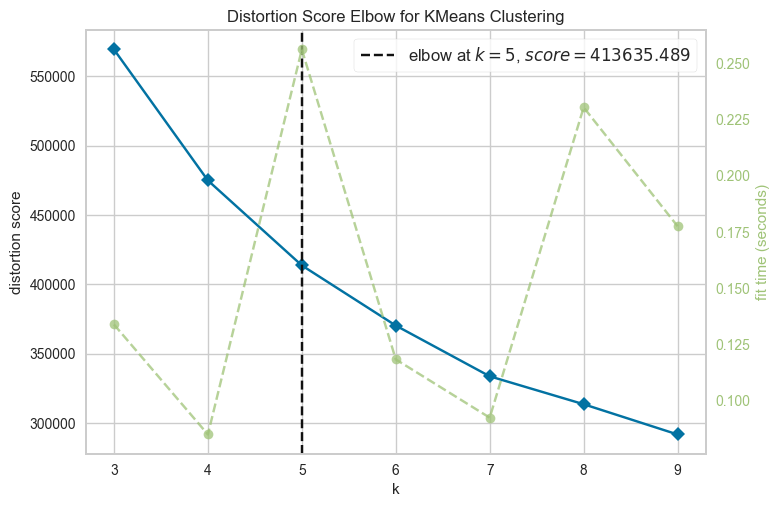

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# pca 시행
pca_df = pca.fit_transform(scale_df)
pca_df = pd.DataFrame(data = pca_df, columns = ['PC1','PC2','PC3'])

#옐로우박스 엘보우로 최적 k값 구하기

# Scree plot for determining the initial k value
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10))

# Fit the visualizer with the PCA data
visualizer.fit(pca_df)
visualizer.show()

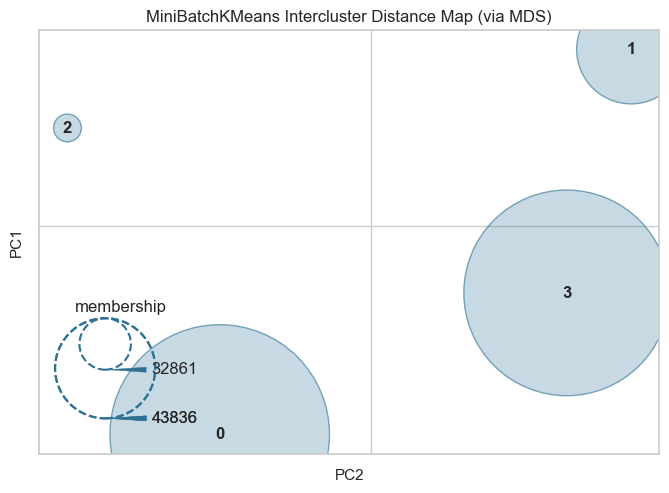

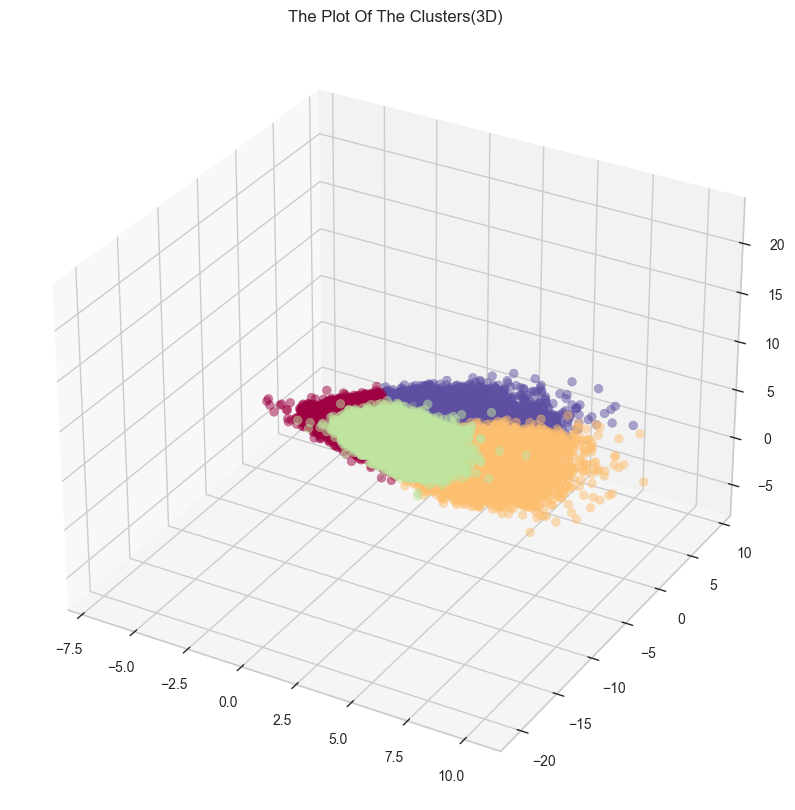

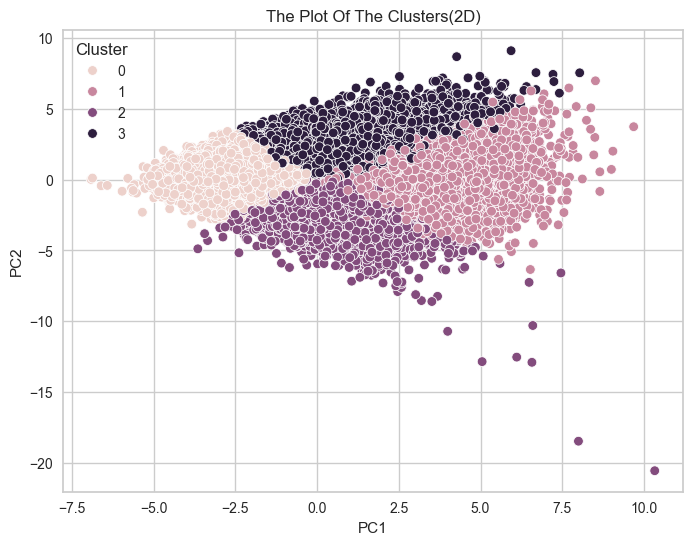

In [49]:
#클러스터링 시각화
#minibatch k
#pca 2, 3차원

intercluster_distance(MiniBatchKMeans(4, random_state=42), pca_df)

#  KMEANS
# 군집개수(n_cluster)는 4,초기 중심 설정방식 랜덤,
kmeans = KMeans(n_clusters=4, random_state=42,init='k-means++')

# pca df 를 이용한 kmeans 알고리즘 적용
kmeans.fit(pca_df)

# 클러스터 번호 가져오기
labels = kmeans.labels_

# 클러스터 번호가 할당된 데이터셋 생성
kmeans_df = pd.concat([pca_df, pd.DataFrame({'Cluster':labels})],axis = 1)

# 클러스터 번호가 할당된 데이터셋 생성
kmeans_df

# 3차원으로 시각화
x =kmeans_df["PC1"]
y =kmeans_df["PC2"]
z =kmeans_df["PC3"]

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=kmeans_df["Cluster"], marker='o', alpha = 0.5, cmap = 'Spectral')
ax.set_title("The Plot Of The Clusters(3D)")

plt.show()

# 2차원으로 시각화

plt.figure(figsize=(8,6))

sns.scatterplot(data = kmeans_df, x = 'PC1', y='PC2', hue='Cluster')
plt.title('The Plot Of The Clusters(2D)')
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# Assuming base_df and labels are already defined
final_df = scale_df.copy()

<Figure size 1000x600 with 0 Axes>

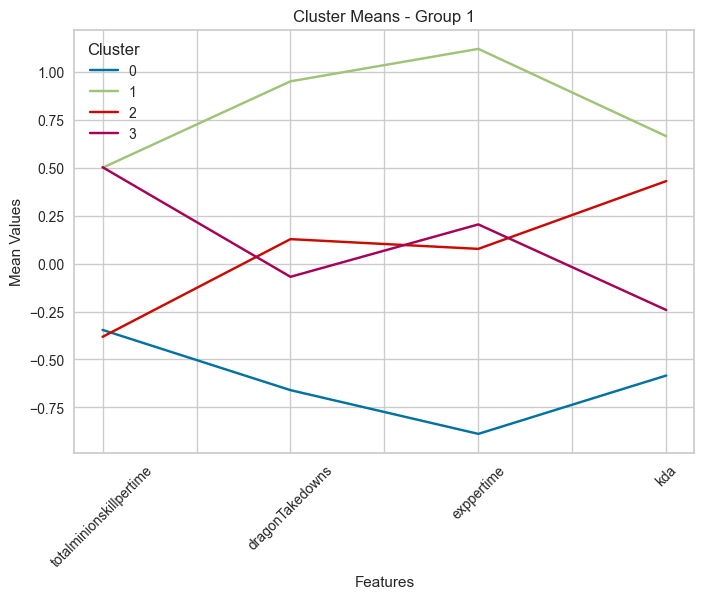

<Figure size 1000x600 with 0 Axes>

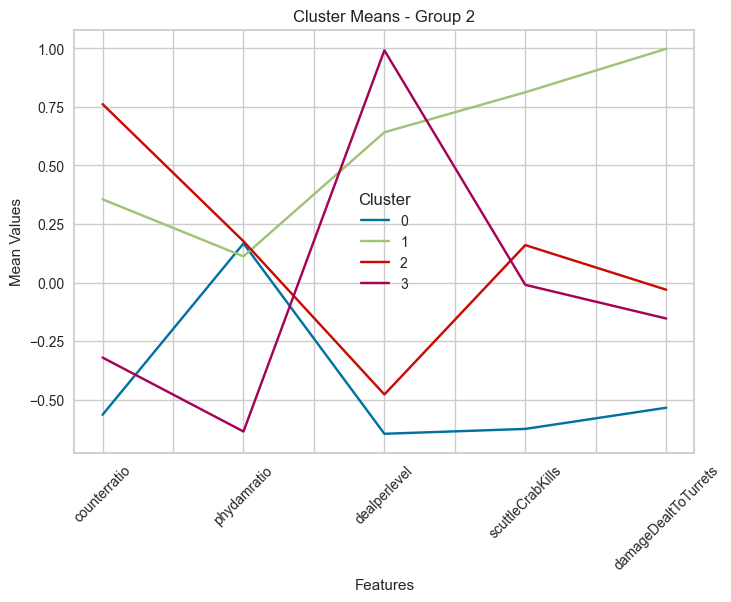

<Figure size 1000x600 with 0 Axes>

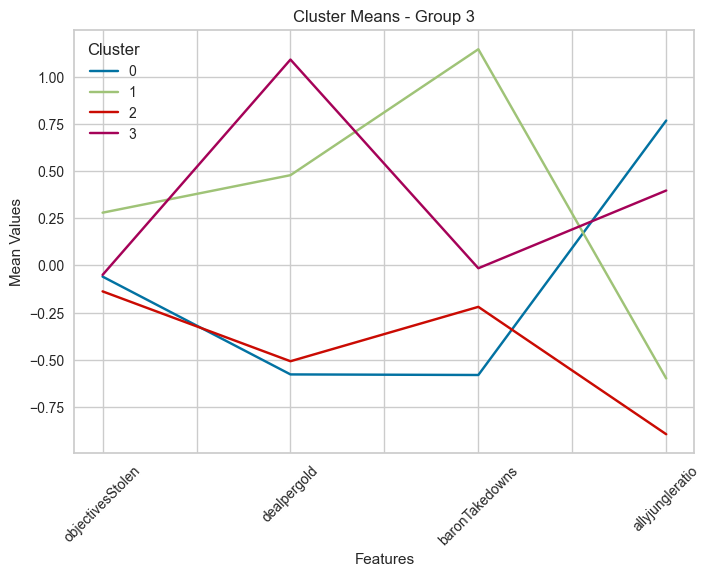

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming base_df and labels are already defined
final_df = scale_df.copy()

# Group selected columns into three sets of five columns each
column_groups = {
'Group 1': feature_names[:4],
'Group 2': feature_names[4:9],
'Group 3': feature_names[9:13]                
}

# Add the cluster labels
final_df2 = final_df.copy()
final_df2['cluster'] = labels.astype(str)

# Create plots for each group
for group_name, columns in column_groups.items():
    plt.figure(figsize=(10, 6))
    cluster_means = final_df2[columns + ['cluster']].groupby('cluster').mean().T
    cluster_means.plot(kind='line')
    plt.title(f"Cluster Means - {group_name}")
    plt.xlabel("Features")
    plt.ylabel("Mean Values")
    plt.xticks(rotation=45) 
    plt.legend(title="Cluster")
    plt.show()

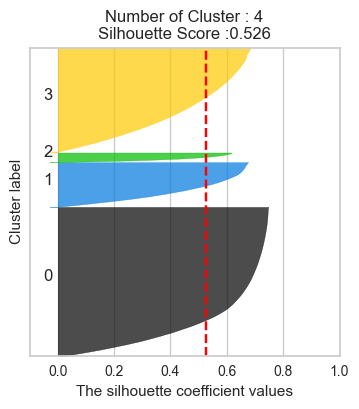

In [23]:
# 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 계수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # axs가 단일 Axes 객체일 경우 리스트로 변환
    if n_cols == 1:
        axs = [axs]

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                        'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

# 클러스터갯수에 따른 실루엣점수
visualize_silhouette([4], clustering_df)

### 클러스터링 이후 해석

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 클러스터 컬럼 붙이기
data = base_df.copy()
data['cluster'] = labels.astype(str)

In [62]:
# 플레이시간 별 평균 수치 보여주는 컬럼 생성
timePlayed_m = data['timePlayed'] / 60
data['timePlayed_m'] = timePlayed_m
data['kills_m'] = data['kills'] / timePlayed_m
data['deaths_m'] = data['deaths'] / timePlayed_m
data['assists_m'] = data['assists'] / timePlayed_m
data['baronKills_m'] = data['baronKills'] / timePlayed_m
data['champExperience_m'] = data['champExperience'] / timePlayed_m
data['champLevel_m'] = data['champLevel'] / timePlayed_m
data['damageDealtToBuildings_m'] = data['damageDealtToBuildings'] / timePlayed_m
data['damageDealtToObjectives_m'] = data['damageDealtToObjectives'] / timePlayed_m
data['damageDealtToTurrets_m'] = data['damageDealtToTurrets'] / timePlayed_m
data['damageSelfMitigated_m'] = data['damageSelfMitigated'] / timePlayed_m
data['detectorWardsPlaced_m'] = data['detectorWardsPlaced'] / timePlayed_m
data['dragonKills_m'] = data['dragonKills'] / timePlayed_m
data['goldEarned_m'] = data['goldEarned'] / timePlayed_m
data['inhibitorTakedowns_m'] = data['inhibitorTakedowns'] / timePlayed_m
data['magicDamageDealtToChampions_m'] = data['magicDamageDealtToChampions'] / timePlayed_m
data['magicDamageTaken_m'] = data['magicDamageTaken'] / timePlayed_m
data['neutralMinionsKilled_m'] = data['neutralMinionsKilled'] / timePlayed_m
data['objectivesStolen_m'] = data['objectivesStolen'] / timePlayed_m
data['objectivesStolenAssists_m'] = data['objectivesStolenAssists'] / timePlayed_m
data['physicalDamageDealtToChampions_m'] = data['physicalDamageDealtToChampions'] / timePlayed_m
data['physicalDamageTaken_m'] = data['physicalDamageTaken'] / timePlayed_m
data['totalAllyJungleMinionsKilled_m'] = data['totalAllyJungleMinionsKilled'] / timePlayed_m
data['totalDamageDealtToChampions_m'] = data['totalDamageDealtToChampions'] / timePlayed_m
data['totalDamageShieldedOnTeammates_m'] = data['totalDamageShieldedOnTeammates'] / timePlayed_m
data['totalDamageTaken_m'] = data['totalDamageTaken'] / timePlayed_m
data['totalEnemyJungleMinionsKilled_m'] = data['totalEnemyJungleMinionsKilled'] / timePlayed_m
data['totalHeal_m'] = data['totalHeal'] / timePlayed_m
data['totalHealsOnTeammates_m'] = data['totalHealsOnTeammates'] / timePlayed_m
data['totalMinionsKilled_m'] = data['totalMinionsKilled'] / timePlayed_m
data['turretTakedowns_m'] = data['turretTakedowns'] / timePlayed_m
data['visionScore_m'] = data['visionScore'] / timePlayed_m
data['alliedJungleMonsterKills_m'] = data['alliedJungleMonsterKills'] / timePlayed_m
data['baronTakedowns_m'] = data['baronTakedowns'] / timePlayed_m
data['controlWardTimeCoverageInRiverOrEnemyHalf_m'] = data['controlWardTimeCoverageInRiverOrEnemyHalf'] / timePlayed_m
data['damageTakenOnTeamPercentage_m'] = data['damageTakenOnTeamPercentage'] / timePlayed_m
data['enemyJungleMonsterKills_m'] = data['enemyJungleMonsterKills'] / timePlayed_m
data['epicMonsterKillsNearEnemyJungler_m'] = data['epicMonsterKillsNearEnemyJungler'] / timePlayed_m
data['epicMonsterSteals_m'] = data['epicMonsterSteals'] / timePlayed_m
data['killsNearEnemyTurret_m'] = data['killsNearEnemyTurret'] / timePlayed_m
data['laningPhaseGoldExpAdvantage_m'] = data['laningPhaseGoldExpAdvantage'] / timePlayed_m
data['maxLevelLeadLaneOpponent_m'] = data['maxLevelLeadLaneOpponent'] / timePlayed_m
data['moreEnemyJungleThanOpponent_m'] = data['moreEnemyJungleThanOpponent'] / timePlayed_m
data['pickKillWithAlly_m'] = data['pickKillWithAlly'] / timePlayed_m
data['scuttleCrabKills_m'] = data['scuttleCrabKills'] / timePlayed_m
data['soloKills_m'] = data['soloKills'] / timePlayed_m
data['takedownsInAlcove_m'] = data['takedownsInAlcove'] / timePlayed_m
data['teamDamagePercentage_m'] = data['teamDamagePercentage'] / timePlayed_m
data['visionScoreAdvantageLaneOpponent_m'] = data['visionScoreAdvantageLaneOpponent'] / timePlayed_m
data['kda_m'] = data['kda'] / timePlayed_m
data['dragonTakedowns_m'] = data['dragonTakedowns']/timePlayed_m

In [63]:
columns_of_interest_m = [
    'cluster', 'timePlayed_m', 'kills_m', 'deaths_m', 'assists_m', 'baronKills_m', 'champExperience_m', 
    'champLevel_m', 'damageDealtToBuildings_m', 'damageDealtToObjectives_m', 
    'damageDealtToTurrets_m', 'damageSelfMitigated_m', 'detectorWardsPlaced_m', 
    'dragonKills_m', 'goldEarned_m', 'inhibitorTakedowns_m', 'magicDamageDealtToChampions_m', 
    'magicDamageTaken_m', 'neutralMinionsKilled_m', 'objectivesStolen_m', 
    'objectivesStolenAssists_m', 'physicalDamageDealtToChampions_m', 'physicalDamageTaken_m', 
    'totalAllyJungleMinionsKilled_m', 'totalDamageDealtToChampions_m', 'totalDamageShieldedOnTeammates_m', 
    'totalDamageTaken_m', 'totalEnemyJungleMinionsKilled_m', 'totalHeal_m', 
    'totalHealsOnTeammates_m', 'totalMinionsKilled_m', 'turretTakedowns_m', 
    'visionScore_m', 'alliedJungleMonsterKills_m', 'baronTakedowns_m', 
    'controlWardTimeCoverageInRiverOrEnemyHalf_m', 'damageTakenOnTeamPercentage_m', 
    'enemyJungleMonsterKills_m', 'epicMonsterKillsNearEnemyJungler_m', 
    'epicMonsterSteals_m', 'killsNearEnemyTurret_m', 'laningPhaseGoldExpAdvantage_m', 
    'maxLevelLeadLaneOpponent_m', 'moreEnemyJungleThanOpponent_m', 'pickKillWithAlly_m', 
    'scuttleCrabKills_m', 'soloKills_m', 'takedownsInAlcove_m', 'teamDamagePercentage_m', 
    'visionScoreAdvantageLaneOpponent_m', 'kda_m', 'dragonTakedowns_m'
]

cluster_means = data.groupby('cluster')[columns_of_interest_m].mean()
overall_mean = data[columns_of_interest_m].mean()
percentage_diff = ((cluster_means - overall_mean) / overall_mean) * 100
percentage_diff_rounded = percentage_diff.round(2)

combined = cluster_means.copy()
for col in cluster_means.columns:
    for cluster in cluster_means.index:
        combined.loc[cluster, col] = f"{cluster_means.loc[cluster, col]:.2f} ({percentage_diff_rounded.loc[cluster, col]:+.2f}%)"

combined

C:\Users\nappi\AppData\Local\Temp\ipykernel_12996\3872212063.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = data.groupby('cluster')[columns_of_interest_m].mean()


,timePlayed_m,kills_m,deaths_m,assists_m,baronKills_m,champExperience_m,champLevel_m,damageDealtToBuildings_m,damageDealtToObjectives_m,damageDealtToTurrets_m,...,maxLevelLeadLaneOpponent_m,moreEnemyJungleThanOpponent_m,pickKillWithAlly_m,scuttleCrabKills_m,soloKills_m,takedownsInAlcove_m,teamDamagePercentage_m,visionScoreAdvantageLaneOpponent_m,kda_m,dragonTakedowns_m
cluster,,,,,,,,,,,,,,,,,,,,,
0,21.75 (-12.29%),0.16 (-35.15%),0.24 (+26.80%),0.20 (-31.95%),0.00 (-86.84%),396.43 (-14.92%),0.54 (-2.85%),12.86 (-74.89%),589.57 (-41.39%),12.86 (-74.89%),...,0.05 (-28.59%),-2.05 (+21.06%),0.31 (-29.30%),0.10 (-20.85%),0.02 (-36.62%),0.01 (-13.77%),0.01 (-0.84%),-0.00 (-140.04%),0.07 (-48.45%),0.03 (-46.81%)
1,29.06 (+17.18%),0.35 (+37.12%),0.14 (-27.80%),0.38 (+28.74%),0.03 (+167.96%),553.64 (+18.82%),0.56 (+1.59%),117.07 (+128.59%),1461.92 (+45.33%),117.07 (+128.59%),...,0.09 (+29.97%),-1.36 (-19.73%),0.55 (+26.71%),0.16 (+19.81%),0.05 (+38.59%),0.01 (+7.33%),0.01 (-6.10%),0.01 (+88.86%),0.20 (+37.04%),0.09 (+56.51%)
2,21.87 (-11.81%),0.28 (+11.42%),0.13 (-31.05%),0.33 (+10.08%),0.01 (-25.14%),471.98 (+1.29%),0.59 (+7.09%),57.75 (+12.76%),1324.30 (+31.65%),57.75 (+12.76%),...,0.09 (+30.57%),-1.70 (+0.29%),0.48 (+10.02%),0.16 (+24.17%),0.04 (+14.78%),0.01 (+15.61%),0.01 (+2.34%),0.01 (+186.38%),0.24 (+65.65%),0.07 (+29.69%)
3,28.88 (+16.45%),0.27 (+6.28%),0.23 (+21.58%),0.33 (+11.80%),0.01 (-7.41%),481.96 (+3.44%),0.52 (-5.30%),36.20 (-29.32%),841.03 (-16.40%),36.20 (-29.32%),...,0.05 (-20.30%),-1.44 (-15.22%),0.48 (+9.47%),0.11 (-14.73%),0.03 (+3.15%),0.01 (-2.72%),0.01 (+5.66%),0.00 (-77.30%),0.09 (-35.36%),0.05 (-17.21%)
